In [2]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.neighbors import NearestNeighbors
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.neighbors import NearestCentroid
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,accuracy_score

from collections import Counter

from statsmodels.stats.outliers_influence import variance_inflation_factor

#plot
import seaborn as sns

2022-05-16 10:06:03.695511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 10:06:03.695610: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Loading Data

In [3]:
data = pd.read_csv('../Data/Frog_Orccurence_Merged.csv') #read data
df = data.drop(['Unnamed: 0','swe','crs','coord','min_lon','max_lon','min_lat','max_lat','ppt_station_influence','tmax_station_influence','tmin_station_influence','vap_station_influence','samples_count'], axis=1)
df.dropna(inplace=True) #drop na
data = df 
data['frog_c'] = data['frog_count'] #moving frog count at the last column
del data['frog_count'] #delete frog_count

# Creating multi-class labels & Encoding the values

In [4]:
data['frog_c'] = pd.qcut(data.frog_c, q=[0, .1,.2,.3, .4,.5, .6,.7, .8,.9, 1], duplicates='drop') #cut frog count into 10 parts

In [5]:
from sklearn.preprocessing import LabelEncoder #encode categorical data
data['frog_count'] = LabelEncoder().fit_transform(data['frog_c']) #encode frog count
data

,aet,def,pdsi,pet,ppt,q,soil,srad,tmax,tmin,vap,vpd,ws,frog_c,frog_count
0,33.159744,13.974441,-1.817252,47.108627,78.827477,37.936102,75.667732,179.063904,7.195527,0.965816,0.634824,0.217764,2.868689,"(0.999, 2.0]",0
1,43.688271,25.219135,-1.712036,68.907410,71.111115,27.459877,57.808643,177.817902,13.687646,6.064506,0.882685,0.413302,1.837037,"(0.999, 2.0]",0
2,43.518520,29.419754,-1.662962,72.938271,64.114197,20.632716,40.885803,175.500000,16.011417,7.849073,0.983673,0.520617,1.531173,"(2.0, 3.0]",1
3,43.132717,29.478395,-1.703086,72.589508,62.481480,19.373457,31.157408,174.320984,16.225307,7.935187,0.977161,0.551327,1.434567,"(0.999, 2.0]",0
4,42.726852,31.567129,-1.737962,74.243057,58.335648,15.562500,29.722221,172.266205,17.848146,8.995373,1.068796,0.627268,1.276852,"(29.0, 13920.0]",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23368,46.930557,1.673611,0.285186,48.599537,128.680557,82.300926,38.729168,130.613419,9.076153,2.054861,0.740949,0.263032,7.082410,"(3.0, 5.0]",2
23369,43.974998,3.097222,0.181389,47.063889,115.258331,71.211111,38.802776,128.677780,8.968613,1.621668,0.737861,0.267750,6.992777,"(0.999, 2.0]",0
23370,41.994446,3.047222,0.368055,45.022221,112.455559,70.608333,39.658333,128.547226,9.012504,1.566112,0.750583,0.252445,7.133328,"(0.999, 2.0]",0
23371,45.187500,3.067130,0.137038,48.261574,120.652779,75.256944,39.361111,128.155090,8.986574,1.611113,0.726482,0.275393,6.997914,"(2.0, 3.0]",1


In [6]:
del data['frog_c'] #delete frog_c which cointains ranges

# Removing Outliers

In [7]:
#Capping the outliers at the 99th and 1st percentile.
def outlier_capping(x): #x is a column
    x = x.clip(upper = x.quantile(0.99)) #cap at 99% quantile
    x = x.clip(lower = x.quantile(0.01)) #cap at 1% quantile
    return x #return capped column

data.iloc[:,0:-7]=data.iloc[:,0:-7].apply(lambda x: outlier_capping(x)) #apply outlier capping to all columns except frog_count

# Splitting into Independent variables and target variables

In [8]:
x = data.drop(['frog_count'], axis=1) #defining x as all columns except frog_count
y = data["frog_count"] #defining y as frog_count

# Oversampling the data, using ADASYM

In [9]:
# import library
from imblearn.over_sampling import ADASYN

rus = ADASYN() #oversampling model

# fit predictor and target varialbe
x_rus, y_rus = rus.fit_resample(x, y)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 10403, 2: 2521, 4: 2334, 6: 2314, 5: 2198, 1: 2052, 3: 1455})
Resample dataset shape Counter({1: 11291, 2: 11094, 3: 10668, 5: 10418, 0: 10403, 4: 10216, 6: 9670})


# Splitting the data into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size=0.3, random_state=42) #split data into train and test

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(51632, 13)
(51632,)
(22128, 13)
(22128,)


# Min Max Scaler

In [12]:
# Data normalization using Minmaxscaler
mm_scaler = MinMaxScaler() #minmax scaler
X_train_mm = mm_scaler.fit_transform(X_train) #fit and transform train data
X_test_mm = mm_scaler.transform(X_test) #transform test data

# Analyzing and removing column based on VIF

In [13]:
# Generating VIF scores & dropping variables having high VIF to avoid multicollinearity
F = pd.DataFrame(X_train_mm,columns=x.columns).drop(['vap','vpd','ppt','srad','pet','tmax','tmin'],axis=1) #defining F as train data without vap,vpd,ppt,srad,pet,tmax,tmin
# VIF dataframe
vif_data = pd.DataFrame() #empty dataframe
vif_data["feature"] = F.columns #feature column
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(F.values, i) for i in range(len(F.columns))] #calculating VIF for each feature

print(vif_data)

  feature       VIF
0     aet  7.080550
1     def  2.394509
2    pdsi  7.033203
3       q  3.488960
4    soil  6.827030
5      ws  8.549731


In [14]:
#'crs','ppt','srad','def','pet','tmax','tmin
X_train_mm=pd.DataFrame(X_train_mm,columns=x.columns).drop(['vap','vpd','ppt','srad','pet','tmax','tmin'],axis=1) #defining X_train_mm as train data without vap,vpd,ppt,srad,pet,tmax,tmin
X_train_mm=X_train_mm.values
X_test_mm=pd.DataFrame(X_test_mm,columns=x.columns).drop(['vap','vpd','ppt','srad','pet','tmax','tmin'],axis=1) #defining X_test_mm as test data without vap,vpd,ppt,srad,pet,tmax,tmin
X_test_mm=X_test_mm.values

In [15]:
print(X_train_mm.shape)
print(y_train.shape)

(51632, 6)
(51632,)


# Building Gaussian Naive Bayes Model

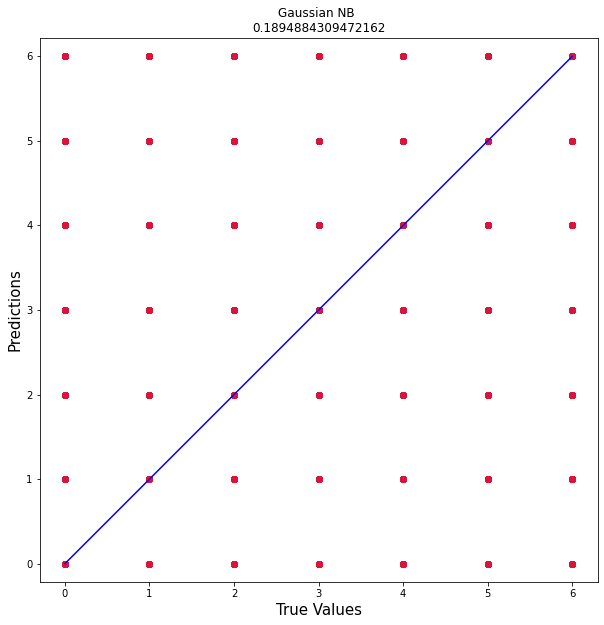

In [16]:
#import naive bayes
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB() # Gaussian Naive Bayes
GNB.fit(X_train_mm, y_train)  # fit model
predicted = GNB.predict(X_test_mm) # predict on test data
x = predicted #predicted values
y = y_test #actual values
plt.figure(figsize=(10,10)) #plot
plt.scatter(y, x, c='crimson') #scatter plot
p1 = max(max(x), max(y)) #max value
p2 = min(min(x), min(y)) #min value 
plt.plot([p1, p2], [p1, p2], 'b-') #plot line
acc =  GNB.score(X_test_mm, y_test) #accuracy
plt.title('Gaussian NB \n' + str(acc)) #title
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

<AxesSubplot:>

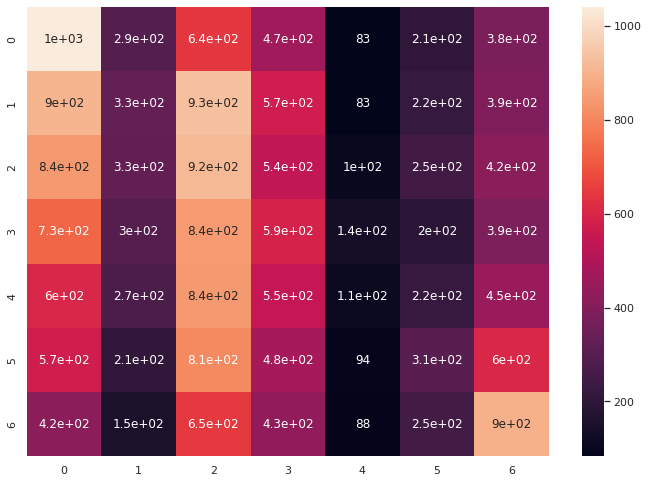

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=[0,1,2,3,4,5,6], index=[0,1,2,3,4,5,6])
sns.heatmap(cm, annot=True)

In [22]:
from sklearn import metrics
print(metrics.classification_report(y, x))

              precision    recall  f1-score   support

           0       0.20      0.33      0.25      3115
           1       0.18      0.10      0.12      3428
           2       0.16      0.27      0.20      3387
           3       0.16      0.19      0.17      3190
           4       0.16      0.04      0.06      3048
           5       0.19      0.10      0.13      3073
           6       0.25      0.31      0.28      2887

    accuracy                           0.19     22128
   macro avg       0.19      0.19      0.17     22128
weighted avg       0.19      0.19      0.17     22128

